In [1]:
import os
import csv
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'geometry_id': str}) for file in hit_files]
random.seed(13)
df = dfs[random.choice(range(len(dfs)))]
df.head()

,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index
0,4503599660924928,936748859932016652,32.748974,-4.660600,14.981686,0.121415,1.388248,-0.187549,0.634454,1.541461,0,0,0,0,1
1,4503600013246464,936748859932016665,29.592871,12.573253,2.681535,0.107632,7.639755,3.256409,0.692612,8.334322,0,0,0,0,0
2,4503599946137600,936748859932016666,28.451805,14.600335,7.083704,0.109270,6.000317,3.089900,1.495002,6.913572,0,0,0,0,0
3,4503599694479360,936748859932016679,-25.811546,-20.364494,-9.063241,0.115488,-0.451405,-0.368699,-0.160661,0.613744,0,0,0,0,0
4,4503599711256576,936748859932016679,-24.150127,-21.668383,0.939645,0.108286,-5.268188,-4.739881,0.205230,7.090385,0,0,0,0,0


Let's see the number of unique geometry ID objects.

In [4]:
print(f"Number of unique geometry IDs: {df['geometry_id'].nunique()}")

Number of unique geometry IDs: 300


## Let's compute the volume, layer and sensitivity information of each geometryID object

In [5]:
import geometry_id

df['volume_id'] = df['geometry_id'].apply(lambda gid: geometry_id.get_volume(gid))
df['layer_id'] = df['geometry_id'].apply(lambda gid: geometry_id.get_layer(gid))
df['sensitivity_id'] = df['geometry_id'].apply(lambda gid: geometry_id.get_sensitivity(gid))

df.iloc[:, -3:].head()

,volume_id,layer_id,sensitivity_id
0,13,2,12
1,13,2,25
2,13,2,26
3,13,2,39
4,13,2,39


In [6]:
print(f"Number of unique volumes: {df['volume_id'].nunique()}")
print(f"Number of unique layers: {df['layer_id'].nunique()}")
print(f"Number of unique sensitivities: {df['sensitivity_id'].nunique()}")
print()
print(f'Number of entries in the dataset: {df.shape[0]}')

Number of unique volumes: 3
Number of unique layers: 4
Number of unique sensitivities: 266

Number of entries in the dataset: 335


Let's plot the counts per unique value.

Text(0.5, 1.0, '\nCount of each volume ID\n')

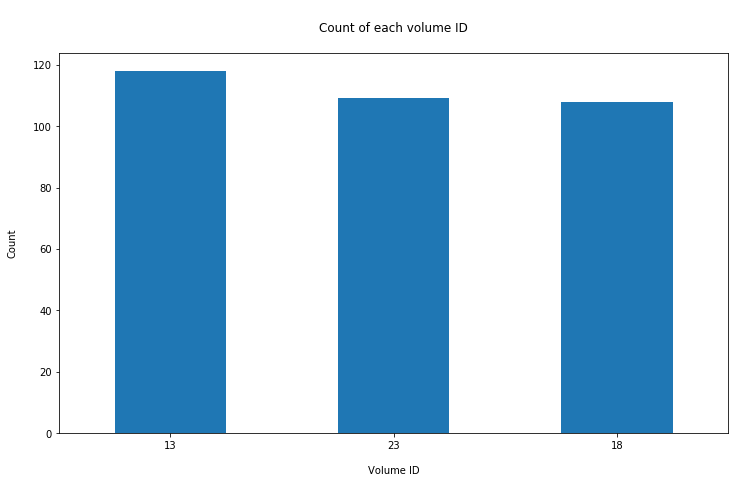

In [7]:
ax = pd.value_counts(df['volume_id']).plot.bar(figsize=(12, 7), rot=0)
ax.set_xlabel('\nVolume ID')
ax.set_ylabel('Count\n')
ax.set_title('\nCount of each volume ID\n')

Text(0.5, 1.0, '\nCount of each layer ID\n')

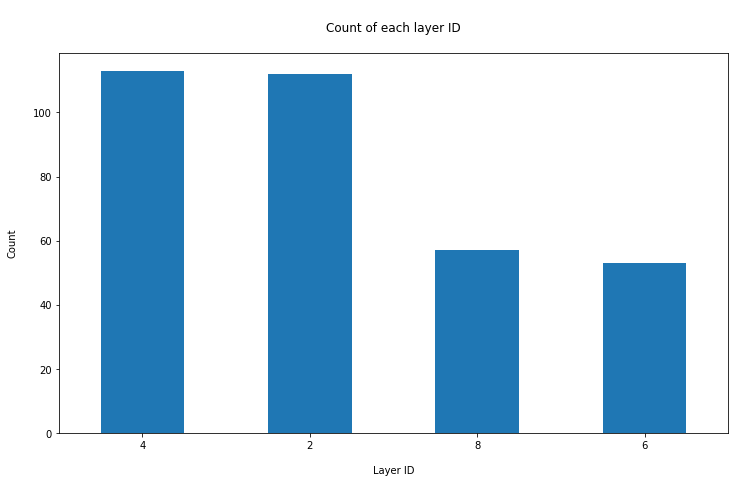

In [8]:
ax = pd.value_counts(df['layer_id']).plot.bar(figsize=(12, 7), rot=0)
ax.set_xlabel('\nLayer ID')
ax.set_ylabel('Count\n')
ax.set_title('\nCount of each layer ID\n')

Text(0.5, 1.0, '\nCount of each sensitivity ID\n')

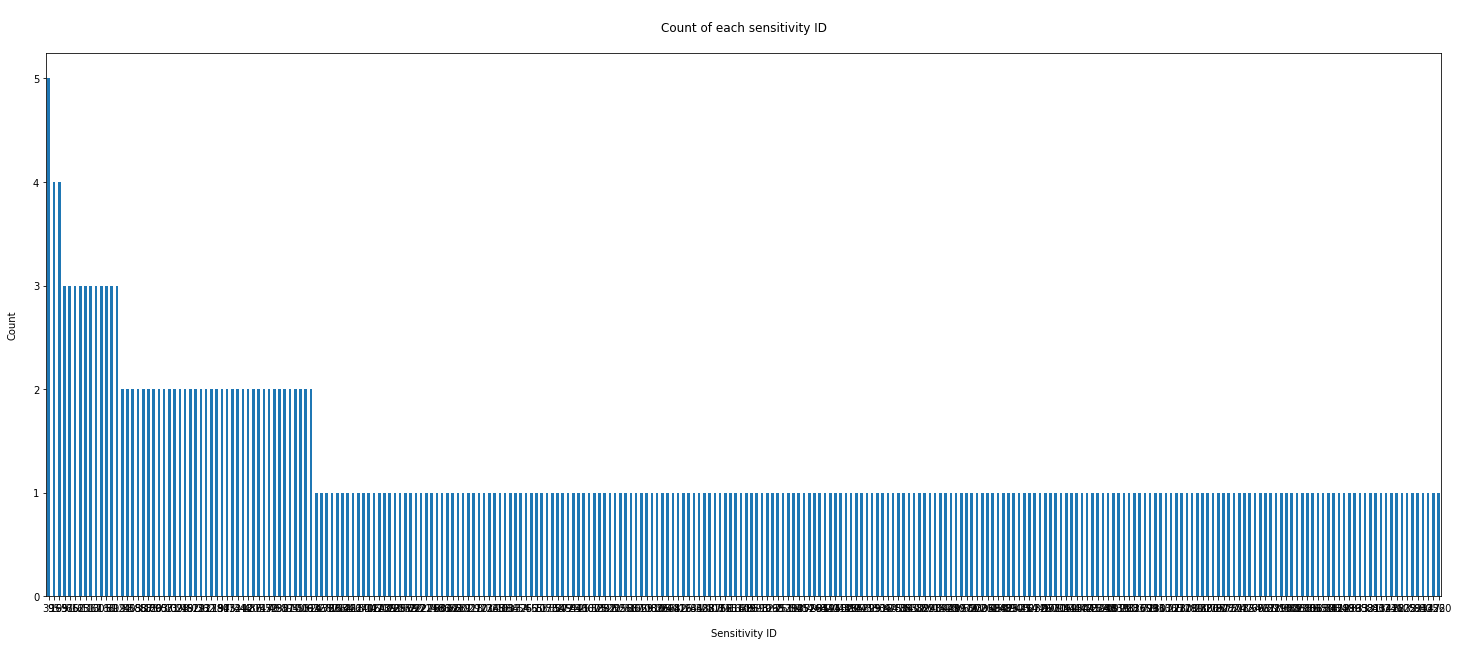

In [9]:
ax = pd.value_counts(df['sensitivity_id']).plot.bar(figsize=(25, 10), rot=0)
ax.set_xlabel('\nSensitivity ID')
ax.set_ylabel('Count\n')
ax.set_title('\nCount of each sensitivity ID\n')

Looks messy. Let's try to keep only the sensitivity IDs with count >= 2.

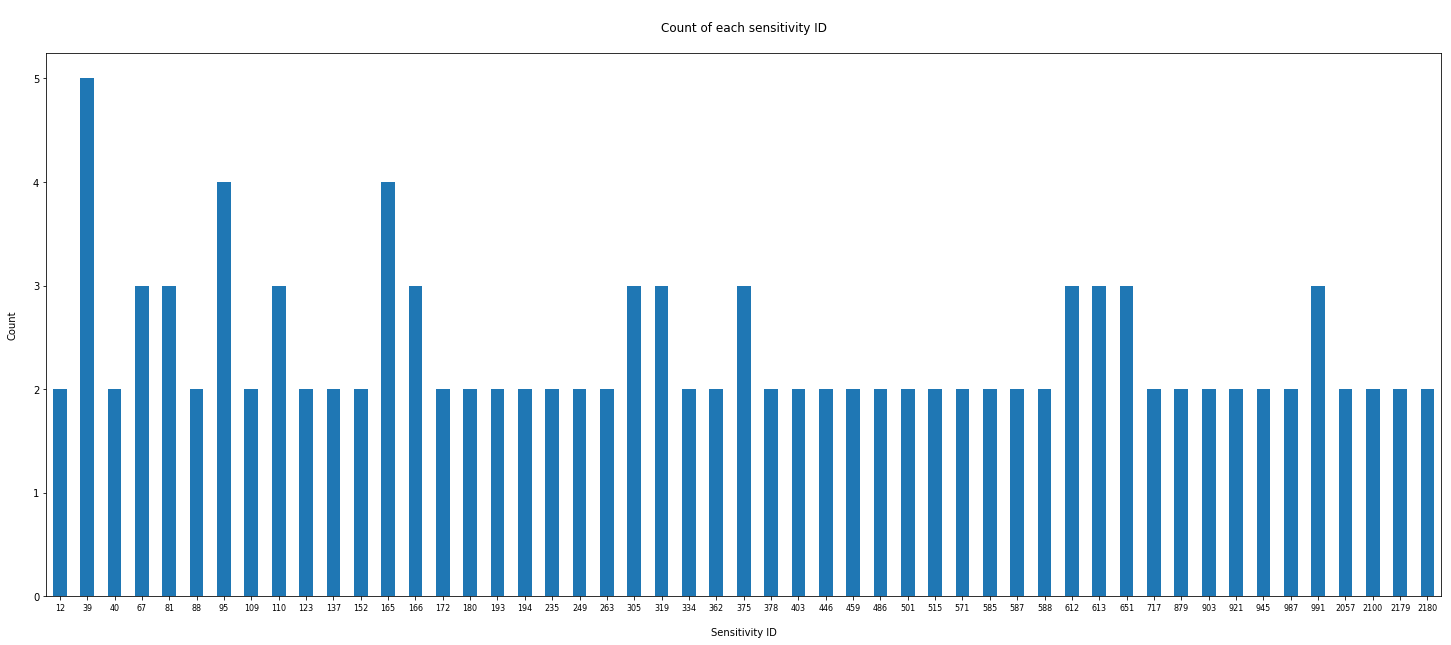

In [10]:
ax = df.groupby(['sensitivity_id']).sensitivity_id.count()[lambda x: x >= 2].plot.bar(figsize=(25, 10), rot=0)
ax.set_xlabel('\nSensitivity ID')
ax.set_ylabel('Count\n')
ax.set_title('\nCount of each sensitivity ID\n')
ax.tick_params(axis='x', labelsize=8)

## Let's now investigate the truth tracks and which geometry objects they encounter

Let's see if there are particles that will go through the _exact_ same geometry ID objects.

In [11]:
unique_particles = set(df['particle_id'])
print(f'Number of different particles in the event: {len(unique_particles)}')
paths_to_count = {}

for pid in unique_particles:
    particle_df = df[df['particle_id'] == pid]
    sequence = tuple(particle_df['geometry_id'])
    paths_to_count[sequence] = paths_to_count.get(sequence, 0) + 1
    
max(paths_to_count.values())

Number of different particles in the event: 25


1

It seems that _no_ two particles will go through the _exact_ same Geometry ID objects. Well this is expected since there are 291 different Geometry ID objects and 329 hits in the dataset. Let's see if some Geometry ID objects get encountered by the same hit of a particle (e.g. the second hit for every particle will go through a specific Geometry ID object).

In [12]:
geometry_index_to_count = {}
geometry_index_to_particle = {}

for pid in unique_particles:
    particle_df = df[df['particle_id'] == pid]
    for idx, (row, series) in enumerate(particle_df.iterrows()):
        gid = series['geometry_id']
        geometry_index_to_count[(gid, idx)] = geometry_index_to_count.get((gid, idx), 0) + 1
        if (gid, idx) not in geometry_index_to_particle:
            geometry_index_to_particle[(gid, idx)] = [pid]
        else:
            geometry_index_to_particle[(gid, idx)].append(pid)

common = {pair: count for pair, count in geometry_index_to_count.items() if count >= 2}
common

{('936748997370970292', 1): 2,
 ('936748859932016679', 0): 3,
 ('936748997370970277', 1): 2,
 ('936749134809923959', 3): 2,
 ('936748859932016707', 0): 3,
 ('936748859932016721', 1): 2,
 ('936748997370970375', 2): 2,
 ('936748859932016735', 0): 3,
 ('936748997370970417', 1): 3,
 ('936749272248877977', 3): 2,
 ('1657324800311298100', 10): 2,
 ('936749134809924169', 2): 2,
 ('936748859932016749', 0): 2,
 ('936748997370970431', 1): 2,
 ('936749272248878047', 4): 2,
 ('936748859932016792', 0): 2,
 ('936748859932016806', 1): 2,
 ('936748997370970558', 2): 2,
 ('936748859932016805', 0): 2,
 ('936748997370970151', 1): 2}

In [13]:
for pair in common:
    common_pids = geometry_index_to_particle[pair]
    gid, idx = pair
    suffix = {1: 'st', 2: 'nd', 3: 'rd'}
    print(f"The {idx + 1}{suffix.get(idx + 1, 'th')} hit of particles {common_pids}, "
          f"was in the same Geometry ID: {gid}\n")

The 2nd hit of particles [4503600013246464, 4503599946137600], was in the same Geometry ID: 936748997370970292

The 1st hit of particles [4503599711256576, 4503599694479360, 4503599744811008], was in the same Geometry ID: 936748859932016679

The 2nd hit of particles [4503599694479360, 4503599744811008], was in the same Geometry ID: 936748997370970277

The 4th hit of particles [4503599694479360, 4503599744811008], was in the same Geometry ID: 936749134809923959

The 1st hit of particles [4503599728033792, 4503599879028736, 4503599895805952], was in the same Geometry ID: 936748859932016707

The 2nd hit of particles [4503599728033792, 4503599879028736], was in the same Geometry ID: 936748859932016721

The 3rd hit of particles [4503599728033792, 4503599879028736], was in the same Geometry ID: 936748997370970375

The 1st hit of particles [4503599811919872, 4503599845474304, 4503599996469248], was in the same Geometry ID: 936748859932016735

The 2nd hit of particles [4503599811919872, 450359

By observing closely this data, we can see that almost all the particles that have hits in common Geometry IDs are grouped in small clusters. For example, the particle with ID "4503600046800896" has common hits _only_ with "4503599761588224", and vice-versa. Maybe this suggests that

1. Sensons (geometry IDs) have a relatively "small" area of effect. By altering a little the trajectory of one particle, it may go through completely different sensors, in a different order.
2. Particles that have very similar tracks, might fall in the same sensors.

We can cross check this by plotting the trajectories of the particles, to see if they are close.

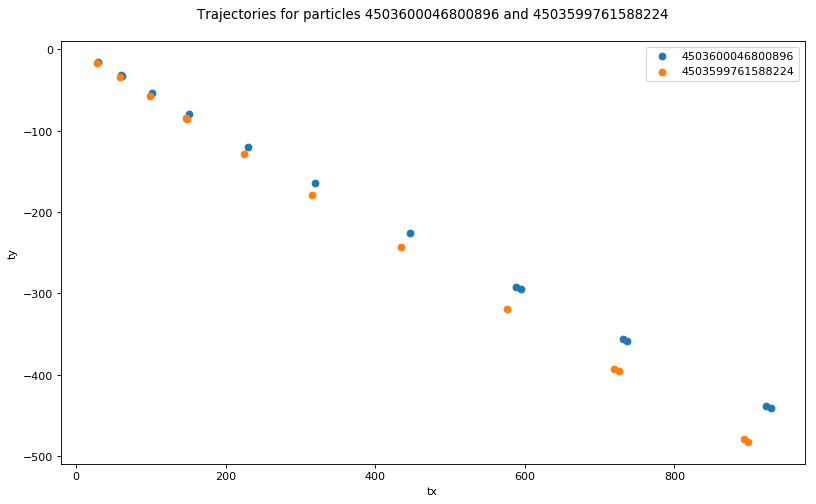

In [14]:
plt.figure(figsize=(12, 7), dpi=80)

p1_df = df[df['particle_id'] == 4503600046800896]
plt.scatter(x=p1_df['tx'], y=p1_df['ty'], label='4503600046800896')
p2_df = df[df['particle_id'] == 4503599761588224]
plt.scatter(x=p2_df['tx'], y=p2_df['ty'], label='4503599761588224')
plt.xlabel('tx')
plt.ylabel('ty')
plt.legend()
plt.title('Trajectories for particles 4503600046800896 and 4503599761588224\n')
plt.show()

Hits 1,2 look indeed really close. Not sure though if this is the reason why they encountered the same geometry ID, since hit 5 does not look really close. Let's now do the same for the volume, layer and sensitivity.

In [15]:
volume_index_to_count = {}
volume_index_to_particle = {}

for pid in unique_particles:
    particle_df = df[df['particle_id'] == pid]
    for idx, (row, series) in enumerate(particle_df.iterrows()):
        vol = series['volume_id']
        volume_index_to_count[(vol, idx)] = volume_index_to_count.get((vol, idx), 0) + 1
        if (vol, idx) not in volume_index_to_particle:
            volume_index_to_particle[(vol, idx)] = [pid]
        else:
            volume_index_to_particle[(vol, idx)].append(pid)

common = {pair: count for pair, count in volume_index_to_count.items() if count >= 2}
for pair, count in common.items():
    vol, idx = pair
    suffix = {1: 'st', 2: 'nd', 3: 'rd'}
    print(f'{count} particles went though volume _{vol}_ in their {idx+1}{suffix.get(idx+1, "th")} hit.\n')

25 particles went though volume _13_ in their 1st hit.

25 particles went though volume _13_ in their 2nd hit.

25 particles went though volume _13_ in their 3rd hit.

24 particles went though volume _13_ in their 4th hit.

15 particles went though volume _13_ in their 5th hit.

21 particles went though volume _18_ in their 6th hit.

25 particles went though volume _18_ in their 7th hit.

24 particles went though volume _18_ in their 8th hit.

18 particles went though volume _18_ in their 9th hit.

8 particles went though volume _18_ in their 10th hit.

24 particles went though volume _23_ in their 11th hit.

24 particles went though volume _23_ in their 12th hit.

20 particles went though volume _23_ in their 13th hit.

11 particles went though volume _23_ in their 14th hit.

10 particles went though volume _18_ in their 5th hit.

7 particles went though volume _23_ in their 9th hit.

17 particles went though volume _23_ in their 10th hit.

5 particles went though volume _23_ in their

We notice that the volume "13" contains most hits in the beggining, while near the end volume "23" is the most common. Now for the layers:

In [16]:
layer_index_to_count = {}
layer_index_to_particle = {}

for pid in unique_particles:
    particle_df = df[df['particle_id'] == pid]
    for idx, (row, series) in enumerate(particle_df.iterrows()):
        layer = series['layer_id']
        layer_index_to_count[(layer, idx)] = layer_index_to_count.get((layer, idx), 0) + 1
        if (layer, idx) not in layer_index_to_particle:
            layer_index_to_particle[(layer, idx)] = [pid]
        else:
            layer_index_to_particle[(layer, idx)].append(pid)

common = {pair: count for pair, count in layer_index_to_count.items() if count >= 2}
for pair, count in common.items():
    layer, idx = pair
    suffix = {1: 'st', 2: 'nd', 3: 'rd'}
    print(f'{count} particles went though layer _{layer}_ in their {idx+1}{suffix.get(idx+1, "th")} hit.\n')

25 particles went though layer _2_ in their 1st hit.

5 particles went though layer _2_ in their 2nd hit.

12 particles went though layer _4_ in their 3rd hit.

13 particles went though layer _6_ in their 4th hit.

13 particles went though layer _8_ in their 5th hit.

12 particles went though layer _2_ in their 6th hit.

11 particles went though layer _4_ in their 7th hit.

10 particles went though layer _6_ in their 8th hit.

6 particles went though layer _6_ in their 9th hit.

7 particles went though layer _8_ in their 10th hit.

18 particles went though layer _2_ in their 11th hit.

9 particles went though layer _2_ in their 12th hit.

17 particles went though layer _4_ in their 13th hit.

11 particles went though layer _4_ in their 14th hit.

20 particles went though layer _4_ in their 2nd hit.

12 particles went though layer _6_ in their 3rd hit.

11 particles went though layer _8_ in their 4th hit.

9 particles went though layer _2_ in their 5th hit.

8 particles went though laye

Again we can notice the popularity of layer _2_ in most cases. Now for the sensitivity:

In [17]:
sensitivity_index_to_count = {}
sensitivity_index_to_particle = {}

for pid in unique_particles:
    particle_df = df[df['particle_id'] == pid]
    for idx, (row, series) in enumerate(particle_df.iterrows()):
        sensitivity = series['sensitivity_id']
        sensitivity_index_to_count[(sensitivity, idx)] = sensitivity_index_to_count.get((sensitivity, idx), 0) + 1
        if (sensitivity, idx) not in sensitivity_index_to_particle:
            sensitivity_index_to_particle[(sensitivity, idx)] = [pid]
        else:
            sensitivity_index_to_particle[(sensitivity, idx)].append(pid)

common = {pair: count for pair, count in sensitivity_index_to_count.items() if count >= 2}
for pair, count in common.items():
    sensitivity, idx = pair
    suffix = {1: 'st', 2: 'nd', 3: 'rd'}
    print(f'{count} particles went had sensitivity _{sensitivity}_ in their {idx+1}{suffix.get(idx+1, "th")} hit.\n')

2 particles went had sensitivity _180_ in their 2nd hit.

2 particles went had sensitivity _334_ in their 3rd hit.

2 particles went had sensitivity _717_ in their 6th hit.

3 particles went had sensitivity _39_ in their 1st hit.

2 particles went had sensitivity _612_ in their 5th hit.

2 particles went had sensitivity _165_ in their 2nd hit.

2 particles went had sensitivity _375_ in their 4th hit.

3 particles went had sensitivity _67_ in their 1st hit.

2 particles went had sensitivity _81_ in their 2nd hit.

2 particles went had sensitivity _263_ in their 3rd hit.

3 particles went had sensitivity _95_ in their 1st hit.

3 particles went had sensitivity _305_ in their 2nd hit.

2 particles went had sensitivity _921_ in their 4th hit.

2 particles went had sensitivity _2100_ in their 11th hit.

2 particles went had sensitivity _585_ in their 3rd hit.

2 particles went had sensitivity _109_ in their 1st hit.

2 particles went had sensitivity _319_ in their 2nd hit.

2 particles went

As we saw earlier, the sensitivity information holds many different values. Hence, there is not much overlapping between the different particles and their sequence of encountering geometry IDs.